<a href="https://colab.research.google.com/github/czarodziejszyn/ssne/blob/main/projekt2/predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import torch
import torch.nn as nn
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
class PredictorBN(nn.Module):
    def __init__(self):
        super(PredictorBN, self).__init__()
        self.lin1 =nn.Linear(23, 142)
        self.bn1 = nn.BatchNorm1d(142)
        self.act1 =nn.ReLU()
        self.lin2 =nn.Linear(142, 71)
        self.bn2 = nn.BatchNorm1d(71)
        self.act2 =nn.ReLU()
        self.lin3 =nn.Linear(71, 1)


    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

In [73]:
class MNISTClassifier_Dropout(nn.Module):
    def __init__(self):
        super(MNISTClassifier_Dropout, self).__init__()
        self.layer1 = nn.Linear(23, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.act1 =  nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)

        self.layer2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)

        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.4)

        self.layer4 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.act1(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = self.act2(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = self.act3(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        x = self.layer4(x)
        return x

In [90]:
train_data = pd.read_csv('train_data.csv')

In [91]:
num_cols = ['SalePrice', 'YearBuilt', 'Size(sqf)', 'Floor',
            'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)', 'N_manager',
            'N_elevators', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
cat_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop',
            'TimeToSubway', 'SubwayStation']

le = LabelEncoder()
train_data['TimeToBusStop'] = le.fit_transform(train_data['TimeToBusStop'])
train_data['TimeToSubway'] = le.fit_transform(train_data['TimeToSubway'])

ohe_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
train_data = pd.get_dummies(train_data, columns=ohe_cols, drop_first=True).astype(float)

In [92]:
def assign_interval(value):
  if value <= 100000:
    return 0
  elif value <= 350000:
    return 1
  else:
    return 2

In [95]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_data.drop('SalePrice', axis=1).values)

y = train_data['SalePrice'].apply(assign_interval)

To jest do nauczenia modelu z podziałem train test

In [97]:
dataset = data.TensorDataset(
    torch.tensor(X_scaled).float(),
    torch.tensor(y).long()
)

train_indices, test_indices = train_test_split(
    list(range(len(dataset))), test_size=0.2, random_state=42
)
train_dataset = data.Subset(dataset, train_indices)
test_dataset = data.Subset(dataset, test_indices)

train_labels = torch.tensor(train_data['SalePrice'].values[train_indices])
class_counts = torch.bincount(train_labels)
class_weights = 1.0 / class_counts.float()
sample_weights = class_weights[train_labels]

sampler = data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = data.DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

To jest do nauczenia modelu przed ostateczną predykcją

In [ ]:
train_dataset = data.TensorDataset(torch.tensor(train_data.drop('SalePrice', axis=1).values).float(),
                                   torch.tensor(train_data['SalePrice'].values).float())
data_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)

Model regresji

In [98]:
model = PredictorBN()
criterion = nn.MSELoss()
opt_bn = torch.optim.Adam(model.parameters(), lr=0.001)

NameError: name 'PredictorBN' is not defined

Model klasyfikacji

In [99]:
model = MNISTClassifier_Dropout()
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(len(class_counts))]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
opt_bn = torch.optim.Adam(model.parameters(), lr=0.0005)

Epoch: 0, Loss: 0.1475086510181427
Epoch: 1, Loss: 0.022347593680024147
Epoch: 2, Loss: 0.02186811901628971
Epoch: 3, Loss: 0.00849812850356102
Epoch: 4, Loss: 0.007325354032218456
Epoch: 5, Loss: 0.0010542571544647217
Epoch: 6, Loss: 0.0013887673849239945
Epoch: 7, Loss: 0.0011777511099353433
Epoch: 8, Loss: 0.00042556438711471856
Epoch: 9, Loss: 0.0005021679680794477
Epoch: 10, Loss: 0.0007070341380313039
Epoch: 11, Loss: 0.0007485976675525308
Epoch: 12, Loss: 0.00019369579968042672
Epoch: 13, Loss: 0.0016074040904641151
Epoch: 14, Loss: 0.00044308858923614025
Epoch: 15, Loss: 0.0014667544746771455
Epoch: 16, Loss: 0.0027318899519741535
Epoch: 17, Loss: 0.0007117228815332055
Epoch: 18, Loss: 9.591896377969533e-05
Epoch: 19, Loss: 0.0011895084753632545
Epoch: 20, Loss: 0.00018537735741119832
Epoch: 21, Loss: 0.0005313653382472694
Epoch: 22, Loss: 0.0015056170523166656
Epoch: 23, Loss: 0.0012487996136769652
Epoch: 24, Loss: 8.634271944174543e-05
Epoch: 25, Loss: 0.00020087712618988007


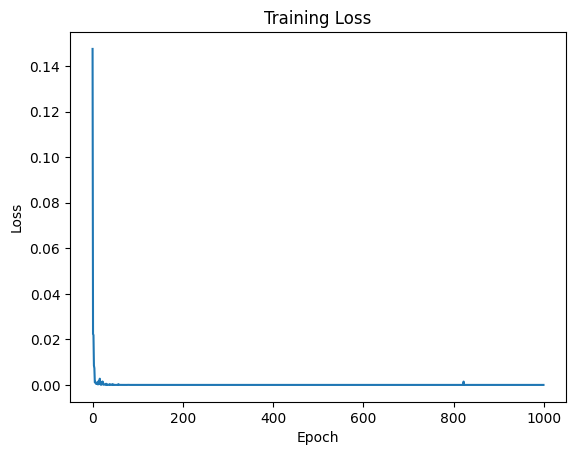

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

losses = []
model.train()
for epoch in range(1000):
  for x, y in train_loader:
    x, y = x.to(device), y.to(device).long()
    opt_bn.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    opt_bn.step()
  losses.append(loss.item())
  print(f"Epoch: {epoch}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Dane testowe

In [ ]:
test_data = pd.read_csv('test_data.csv')

le = LabelEncoder()
test_data['TimeToBusStop'] = le.fit_transform(test_data['TimeToBusStop'])
test_data['TimeToSubway'] = le.fit_transform(test_data['TimeToSubway'])

ohe_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
test_data = pd.get_dummies(test_data, columns=ohe_cols, drop_first=True).astype(float)

Model bez uczenia do walidowania regresji

In [101]:
model.eval()
y_pred_list = []
y_true_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
  for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_pred_list.extend(y_pred_classes.cpu().numpy().tolist())
    y_true_list.extend(y.cpu().numpy().tolist())


correct_predictions = sum([1 for i in range(len(y_pred_list)) if y_pred_list[i] == y_true_list[i]])
accuracy = (correct_predictions / len(y_pred_list)) * 100

print(f"Classification accuracy: {accuracy:.2f}%")

Classification accuracy: 100.00%
